# Update
### read_date(file_path)
* input: file_path
* output: 
     - csr: csr matrix of user profile data
     - courses: list of courses
     
### svd_based(csr, courses, user_input, num_factors = 100, top_n = 10, random_state=42)
* input: 
    - csr
    - courses
    - user_input
    - other inputs can be assigned inside the function. 
    
* output:
    - recommended courses
    
--------


# Pipeline

### read_data(file_path)
- read data to df

### concat_user_input_and_convert_to_csr(df, user_input): 
- df: output df from read_data
- user_input: list of courses the user provide
- Append user input to the df and convert the df into csr. 
- Returns csr matrix, and course list.

### svd_based(uc_mat, courses, user_idx = -1, num_factors=80, top_n = 10, random_state=42):
- uc_mat: csr matrix (1st output of concat_user_input_and_convert_to_csr)
- courses: course list (2nd output of concat_user_input_and_convert_to_csr)
- num_factors: hyperparam of svd
- top_n: num of recommendation
- Returns top_n recommended courses

---------


# This notebook
* Try three different collaborative filterings: Memory, SVD, NMF
* Speed: SVD - Memory - NMF (fast to slow)
* RMSE: SVD - NMF - Memory (low to high)


* Winner: SVD

## Note
* Parameter tuning (SVD: num_factors)

In [1]:
import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix
from scipy.sparse import coo_matrix, vstack
import pickle

## Load the data and convert into sparse matrix

### Update: read_data will take a file_path and output a csr and course list. 

In [2]:
def read_data(file_path):
    from scipy.sparse import csr_matrix
    
    # Read pickle
    stu = pd.read_pickle(file_path)
    
    # Num of dictionaries in the file
    n = len(stu)
    
    # Initialize df
    df = pd.DataFrame()
    
    # Loop through dicts and concat
    for i in range(n):
        stu[i]['student_id'] = i
        df = pd.concat([df,stu[i]])
    
    # df = user dataset we have
    # user_input: courses that user provide

    # Fix .0 issues -- Some courses has .0 at the end (e.g. AAS 101.0), remove .0
    df.loc[df['Subject/Catalog'].str.contains('\.') == True, 'Subject/Catalog'] = df.loc[df['Subject/Catalog'].str.contains('\.') == True, 'Subject/Catalog'].str.split('\.').str[0]
    
    # Pivot table to stu - course
    df = pd.pivot_table(df, values = 'Rating', index = 'student_id', columns = 'Subject/Catalog')
    
    # Fillna
    df = df.fillna(0)
    
    # df to sparse matrix
    csr = csr_matrix(df)
    
    # Store course names
    courses = list(df.columns)
    

    return csr, courses 

In [8]:
csr, courses = read_data('student_profiles.pickle')

### Store user profile csr and the list of courses

In [9]:
with open('csr.pkl', "wb") as fOut:
    pickle.dump(csr, fOut, protocol=pickle.HIGHEST_PROTOCOL)
    
with open('courses.pkl', "wb") as fOut:
    pickle.dump(courses, fOut, protocol=pickle.HIGHEST_PROTOCOL)

### Load csr and courses

In [10]:
with open('csr.pkl', "rb") as fIn:
    csr = pickle.load(fIn)
with open('courses.pkl', "rb") as fIn:
     courses = pickle.load(fIn)

In [11]:
# random user input
user_input = np.random.choice(courses, size = 10, replace = False)

## Matrix-based collaborative filtering

In [ ]:
from sklearn.decomposition import TruncatedSVD

def svd_based(csr, courses, user_input, num_factors = 100, top_n = 10, random_state=42):
    # SVD based collaborative filtering
    user_row = np.isin(courses, user_input)
    uc_mat = vstack([csr, user_row]).tocsr()
    
    user_idx = -1

    
    # SVD
    svd = TruncatedSVD(n_components = num_factors, random_state = random_state)
    
    # Transform X
    X_transformed = svd.fit_transform(uc_mat)
    
    # Calculate r
    r = np.matmul(X_transformed, svd.components_)
    
    # Pred rating
    pred_rating = r[user_idx,:]#.reshape(1,-1)
    
    
    # Matched user vector
    user_vec = uc_mat[user_idx].toarray().flatten()
    
    
    # User's favorite course indices
    user_fav_idx = np.argsort(-user_vec)

    
    # Flatten pred_rating
    pred_rating = np.asarray(pred_rating).flatten()
    
    # Argsort the rating except the courses taken by the user
    recommend_index = np.argsort(-pred_rating[user_vec == 0])
    
    # Recommend top courses
    top_courses = [courses[i] for i in recommend_index[:top_n]]

    # RMSE between true & predicted. Uncomment the next two lines to see RMSE
    #rmse = np.sqrt(np.sum((user_vec[user_vec != 0] - pred_rating[user_vec != 0]) ** 2))
    #print(f"RMSE = {rmse}")
    
    return top_courses#, rmse

In [ ]:
user_input = np.random.choice(courses, size = 10, replace = False)
svd_based(csr, courses, user_input)



-----------------
 

### uncomment rmse in return line to run the next codes

In [346]:
r_list = []
for _ in range(100):
    pred, rmse = svd_based(csr, courses, user_input)
    r_list.append(rmse)
print(np.average(r_list))

Runtime : 1.051058120000016
3.1114267946773877


In [373]:
%%timeit
user_input = np.random.choice(courses, size = 10, replace = False)
pred, rmse = svd_based(csr, courses, user_input)

571 ms ± 67.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Calculate avg RMSE of SVD with diff n_factors

In [63]:
subcat = df['Subject/Catalog'].unique()

In [218]:
import numpy as np
def svd_tune(df, num_factors, top_n = 10, random_state=42):
    # SVD based collaborative filtering
    
    # user_idx = -1
    user_idx = -1
    rmse_list = []
    for i in range(100):
        user_input = np.random.choice(courses, size = 10, replace = False)
        uc_mat, courses = concat_user_input_and_convert_to_csr(df, user_input)

        # SVD
        svd = TruncatedSVD(n_components = num_factors, random_state = random_state)

        # Transform X
        X_transformed = svd.fit_transform(uc_mat)

        # Calculate r
        r = np.matmul(X_transformed, svd.components_)

        # Pred rating
        pred_rating = r[user_idx,:]#.reshape(1,-1)


        # Matched user vector
        user_vec = uc_mat[user_idx].toarray().flatten()


        # User's favorite course indices
        user_fav_idx = np.argsort(-user_vec)

        # User's favorite courses
        #user_fav = [courses[i] for i in user_fav_idx[:top_n]]
        #print(f"Top {top_n} favorite courses:")
        #print(user_fav)


        # Flatten pred_rating
        pred_rating = np.asarray(pred_rating).flatten()

        # Argsort the rating except the courses taken by the user
        recommend_index = np.argsort(-pred_rating[user_vec == 0])

        # Recommend top courses
        top_courses = [courses[i] for i in recommend_index[:top_n]]


        # RMSE between true & predicted. Uncomment the next two lines to see RMSE
        rmse_list.append(np.sqrt(np.sum((user_vec[user_vec != 0] - pred_rating[user_vec != 0]) ** 2)))
    avg_rmse = np.average(rmse_list)
    #print(f"RMSE = {avg_rmse}")
    
    return avg_rmse

In [62]:
avg_rmse_list = []
for num in [50, 55, 60, 65, 70, 75, 80, 85, 90]:
    avg_rmse = svd_tune(df, num, top_n = 10, random_state=42)
    avg_rmse_list.append(avg_rmse)
    

RMSE = 4.364242197081958
RMSE = 4.357827404798507
RMSE = 4.359784457612434
RMSE = 4.346068447475665
RMSE = 4.337082405850965
RMSE = 4.330620854141026
RMSE = 4.320117968276278
RMSE = 4.324448355403818
RMSE = 4.30260091539495


### As the number goes up, the RMSE gets smaller. Please scroll down for RMSE, Explained Variance in range of (50, 800).

-------------

### Let's take a look at time

In [359]:
def svd_time(df, num_factors, top_n = 10, random_state=42):
    # SVD based collaborative filtering
    
    # user_idx = -1
    user_idx = -1
    rmse_list = []
    for i in range(10):
        user_input = np.random.choice(courses, size = 10, replace = False)

        user_row = np.isin(courses, user_input)
        uc_mat = vstack([csr, user_row]).tocsr()

        user_idx = -1

        # SVD
        svd = TruncatedSVD(n_components = num_factors, random_state = random_state)

        # Transform X
        X_transformed = svd.fit_transform(uc_mat)

        # Calculate r
        r = np.matmul(X_transformed, svd.components_)

        # Pred rating
        pred_rating = r[user_idx,:]#.reshape(1,-1)


        # Matched user vector
        user_vec = uc_mat[user_idx].toarray().flatten()


        # User's favorite course indices
        user_fav_idx = np.argsort(-user_vec)

        # User's favorite courses
        #user_fav = [courses[i] for i in user_fav_idx[:top_n]]
        #print(f"Top {top_n} favorite courses:")
        #print(user_fav)


        # Flatten pred_rating
        pred_rating = np.asarray(pred_rating).flatten()

        # Argsort the rating except the courses taken by the user
        recommend_index = np.argsort(-pred_rating[user_vec == 0])

        # Recommend top courses
        top_courses = [courses[i] for i in recommend_index[:top_n]]

    
    return None

In [361]:
import time
x = np.arange(50, 400, 50)
runtime_list = []
for num in x:
    start = time.process_time()
    pred = svd_time(df, num)   
    runtime = (time.process_time() - start)
    runtime_list.append(runtime/10)
    print(runtime/10)

0.7557066999994276
1.2164796999997634
1.7267242999994779
2.316880200000014
2.928143399999681
3.291754000000219
3.6796705000000656


### At n_components = 50, it takes 2.6s. At n_components = 750, it takes 10.5s.
### Here is a plot of n_components and time

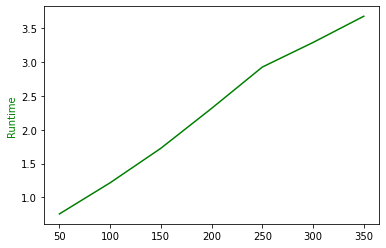

In [369]:
import matplotlib.pyplot as plt
import seaborn as sns
fig, ax1 = plt.subplots()

x = np.arange(50, 400, 50)
ax1.plot(x, runtime_list, color = 'green')
ax1.set_ylabel('Runtime', color = 'green')

plt.show()

## SVD hyperparameter tuning - Bayesian optimization

In [67]:
#pip install bayesian-optimization

  Created wheel for bayesian-optimization: filename=bayesian_optimization-1.2.0-py3-none-any.whl size=11685 sha256=66c6540c73156f630062a7533f31207b79a0e40505d64949e6d2badf702820a3
  Stored in directory: /Users/Yeseul/Library/Caches/pip/wheels/37/fa/19/f93e793d3944567a60b3ab93b446cf7370cc82c60c1d1c613f
Successfully built bayesian-optimization
Note: you may need to restart the kernel to use updated packages.


In [90]:
from bayes_opt import BayesianOptimization

def BO_func(n_components):
    avg_rmse = svd_tune(df, int(n_components), top_n = 10, random_state=42)
    return -avg_rmse

In [91]:
%%time
tuning_params = { 
  "n_components": (100, 150) }

optimizer = BayesianOptimization(
  f = BO_func,
  pbounds = tuning_params,
  verbose = 5,
  random_state = 42
 )

optimizer.maximize(
  init_points = 4,
  n_iter = 3 
 )

|   iter    |  target   | n_comp... |
-------------------------------------
|  1        | -3.087    |  118.7    |
|  2        | -3.061    |  147.5    |
|  3        | -3.087    |  136.6    |
|  4        | -3.083    |  129.9    |
|  5        | -3.067    |  146.6    |
|  6        | -3.083    |  150.0    |
|  7        | -3.068    |  144.2    |
CPU times: user 32min 52s, sys: 5min 50s, total: 38min 42s
Wall time: 31min 21s


### RMSE is smallest at the highest n_components(150) of the range(100, 150)
### Let's try broader range (50, 500)

In [93]:
tuning_params = { 
  "n_components": (50, 500) }


from bayes_opt import BayesianOptimization

optimizer = BayesianOptimization(
  f = BO_func,
  pbounds = tuning_params,
  verbose = 5,
  random_state = 42
 )

optimizer.maximize(
  init_points = 4,
  n_iter = 3 
 )

|   iter    |  target   | n_comp... |
-------------------------------------
|  1        | -3.024    |  218.5    |
|  2        | -2.86     |  477.8    |
|  3        | -2.903    |  379.4    |
|  4        | -2.96     |  319.4    |
|  5        | -2.848    |  500.0    |
|  6        | -2.814    |  498.8    |
|  7        | -2.849    |  494.9    |


### Similar result. RMSE is lowest at n_components = 499 in range (50, 500)

--------



## Explained Variance

In [108]:
import numpy as np
def svd_var(df, num_factors, top_n = 10, random_state=42):
    # SVD based collaborative filtering
    
    # user_idx = -1
    user_idx = -1
    explained_variance_list = []
    rmse_list = []
    for i in range(100):
        user_input = np.random.choice(courses, size = 10, replace = False)
        uc_mat, courses = concat_user_input_and_convert_to_csr(df, user_input)

        # SVD
        svd = TruncatedSVD(n_components = num_factors, random_state = random_state)

        # Transform X
        X_transformed = svd.fit_transform(uc_mat)

        # Calculate r
        r = np.matmul(X_transformed, svd.components_)

        # Pred rating
        pred_rating = r[user_idx,:]#.reshape(1,-1)


        # Matched user vector
        user_vec = uc_mat[user_idx].toarray().flatten()


        # User's favorite course indices
        user_fav_idx = np.argsort(-user_vec)

        # User's favorite courses
        #user_fav = [courses[i] for i in user_fav_idx[:top_n]]
        #print(f"Top {top_n} favorite courses:")
        #print(user_fav)


        # Flatten pred_rating
        pred_rating = np.asarray(pred_rating).flatten()

        # Argsort the rating except the courses taken by the user
        recommend_index = np.argsort(-pred_rating[user_vec == 0])

        # Recommend top courses
        top_courses = [courses[i] for i in recommend_index[:top_n]]


        # RMSE between true & predicted. 
        rmse_list.append(np.sqrt(np.sum((user_vec[user_vec != 0] - pred_rating[user_vec != 0]) ** 2)))
        
        # Explained variance 
        explained_variance_list.append(svd.explained_variance_ratio_.sum())
    
    avg_ev = np.average(explained_variance_list)
    avg_rmse = np.average(rmse_list)

    
    return avg_ev, avg_rmse

In [109]:
n = np.arange(50, 500, 50)
avg_ev_list = []
avg_rmse_list = []
for num in n:
    avg_ev, avg_rmse = svd_var(df, num, top_n = 10, random_state=42)
    avg_ev_list.append(avg_ev)
    avg_rmse_list.append(avg_rmse)
    print("n_components: ",num, " Explained variance sum: ", avg_ev, ' RMSE: ', avg_rmse)
    

n_components:  50  Explained variance sum:  0.2069566432419802  RMSE:  3.136881940437139
n_components:  100  Explained variance sum:  0.3080865954789482  RMSE:  3.1243334888200214
n_components:  150  Explained variance sum:  0.37026838778355925  RMSE:  3.048886230162509
n_components:  200  Explained variance sum:  0.41887893620543243  RMSE:  3.0507622788673108
n_components:  250  Explained variance sum:  0.4610223165101213  RMSE:  3.0041577221473976
n_components:  300  Explained variance sum:  0.4989714855659057  RMSE:  2.9756654305757753
n_components:  350  Explained variance sum:  0.5332084669994797  RMSE:  2.932978723556314
n_components:  400  Explained variance sum:  0.5642925077415119  RMSE:  2.8732756662024808
n_components:  450  Explained variance sum:  0.592669329422925  RMSE:  2.8446796399219165


In [110]:
n = np.arange(500, 800, 50)
for num in n:
    avg_ev, avg_rmse = svd_var(df, num, top_n = 10, random_state=42)
    avg_ev_list.append(avg_ev)
    avg_rmse_list.append(avg_rmse)
    print("n_components: ",num, " Explained variance sum: ", avg_ev, ' RMSE: ', avg_rmse)
    

n_components:  500  Explained variance sum:  0.6187698018564972  RMSE:  2.8370689935019273
n_components:  550  Explained variance sum:  0.642819555062698  RMSE:  2.756939016177228
n_components:  600  Explained variance sum:  0.6654379541743018  RMSE:  2.7701917618079115
n_components:  650  Explained variance sum:  0.6865863661990289  RMSE:  2.6958564337227897
n_components:  700  Explained variance sum:  0.706502879828708  RMSE:  2.7041602167885803
n_components:  750  Explained variance sum:  0.7252492577436896  RMSE:  2.6473528552518335


### Explained variance goes up and RMSE goes down as n_components gets higher. 
### Here is a plot for it.

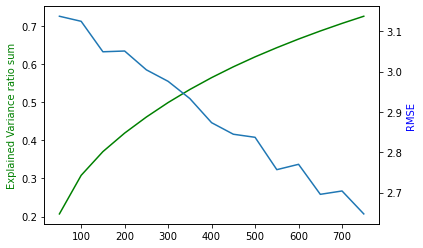

In [206]:
import matplotlib.pyplot as plt
import seaborn as sns
fig, ax1 = plt.subplots()

x = np.arange(50, 800, 50)
ax1.plot(x, avg_ev_list, color = 'green')
ax1.set_ylabel('Explained Variance ratio sum', color = 'green')
ax2 = ax1.twinx()
ax2.plot(x, avg_rmse_list)
ax2.set_ylabel('RMSE', color = 'blue')
plt.show()

### No 'drops' that we could pick as a cut-off for n_components. 

--------

## GridsearchCV

In [186]:
from sklearn.metrics import make_scorer
user_input = np.random.choice(courses, size = 10, replace = False)

def my_scorer(estimator, X, y=None):
    avg_rmse = []
    for i in range(100):
    
        # SVD
        svd = TruncatedSVD(random_state = 42)

        # Transform X
        X_transformed = estimator.fit_transform(data)

        # Calculate r
        r = np.matmul(X_transformed, estimator.components_)
        
        user_idx = np.random.randint(0, r.shape[0])
        
        # Pred rating
        pred_rating = r[user_idx,:]


        # Matched user vector
        user_vec = uc_mat[user_idx].toarray().flatten()

        # User's favorite course indices
        user_fav_idx = np.argsort(-user_vec)

        # Flatten pred_rating
        pred_rating = np.asarray(pred_rating).flatten()



        # RMSE between true & predicted. Uncomment the next two lines to see RMSE
        rmse = np.sqrt(np.sum((user_vec[user_vec != 0] - pred_rating[user_vec != 0]) ** 2))
        avg_rmse.append(rmse)

    np.average(avg_rmse)
    return -rmse

In [187]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import  make_scorer

new_df = pd.pivot_table(df, values = 'Rating', index = 'student_id', columns = 'Subject/Catalog').fillna(0)
data = csr_matrix(new_df)
svd = TruncatedSVD(random_state = 42)
#scorer = make_scorer(my_scorer, greater_is_better = False)
param_grid = {'n_components':[50, 100, 150, 200, 250, 300]}
gs = GridSearchCV(svd, param_grid, scoring=my_scorer, cv=3)
gs.fit(data)



GridSearchCV(cv=3, estimator=TruncatedSVD(random_state=42),
             param_grid={'n_components': [50, 100, 150, 200, 250, 300]},
             scoring=<function my_scorer at 0x7fc860fffca0>)

In [188]:
gs.best_params_

{'n_components': 300}

In [189]:
gs.best_score_

-11.773772114827802

In [190]:
gs.cv_results_

{'mean_fit_time': array([0.13703934, 0.27785134, 0.4588356 , 0.62833047, 0.8306125 ,
        1.12829105]),
 'std_fit_time': array([0.00335502, 0.03936612, 0.03306965, 0.00537788, 0.02571323,
        0.33875267]),
 'mean_score_time': array([ 32.87845596,  54.3493673 ,  75.6324776 , 103.56576721,
        130.96367971, 164.81422973]),
 'std_score_time': array([0.43390867, 2.22713671, 0.75666458, 2.42060683, 1.27256143,
        3.08446854]),
 'param_n_components': masked_array(data=[50, 100, 150, 200, 250, 300],
              mask=[False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'n_components': 50},
  {'n_components': 100},
  {'n_components': 150},
  {'n_components': 200},
  {'n_components': 250},
  {'n_components': 300}],
 'split0_test_score': array([-15.72707967, -14.46666661, -14.26611437, -12.61420054,
        -13.07340963, -13.37956634]),
 'split1_test_score': array([-15.78328898, -15.7867201 , -13.70534381, -12.42263407,
   

### GridSearchCV will give me similar result. Just spit out the biggest n_components I fed. 

----------
----------

## Memory-based collaborative filtering

In [354]:
import scipy.sparse
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity


def memory_based(csr, courses, user_input, top_n):
    # Memory-based collaborative filtering
    
    
    user_row = np.isin(courses, user_input)
    uc_mat = vstack([csr, user_row]).tocsr()
    # Normalize user-course matrix
    norm_uc_mat = uc_mat - uc_mat.mean(axis = 1).reshape(-1,1)
    
    # Cosine similarity of raw matrix
    cossim = cosine_similarity(uc_mat)
    
    # Calculate the numerator of V-hat(aj)
    v_num = np.dot(cossim[user_idx,:], norm_uc_mat)
    
    # Sum of V-hat(aj) numerator
    v_num_sum = v_num.sum(axis = 0)
    
    # V_hat(aj)
    v_hat = v_num_sum/(cossim[user_idx,:].sum())
    
    #Predicted rating of each course
    pred_rating = np.add(v_hat, uc_mat.mean(axis = 1).reshape(-1,1)[user_idx])
    
    # User vector
    user_vec = uc_mat[user_idx].toarray().flatten()
    
    # User's favorite course indices
    user_fav_idx = np.argsort(-user_vec)
    
    # User's favorite courses
    user_fav = [courses[i] for i in user_fav_idx[:top_n]]
    #print(f"Top {top_n} favorite courses:")
    #print(user_fav)
    
    # Flatten pred_rating
    pred_rating = np.asarray(pred_rating).flatten()
    
    
    # Argsort the rating except the courses taken by the user
    recommend_index = np.argsort(-pred_rating[user_vec == 0])
    
    # Recommend top courses
    top_courses = [courses[i] for i in recommend_index[:top_n]]
    
    #print(f"Top {top_n} recommended courses:")
    #print(top_courses)

    #print()

    # RMSE between true & predicted
    rmse = np.sqrt(np.sum((user_vec[user_vec != 0] - pred_rating[user_vec != 0]) ** 2))
    #print(f"RMSE = {rmse}")
    
    return top_courses, rmse



In [367]:
%%timeit
pred = memory_based(csr, courses, user_input, 10)

971 ms ± 9.04 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [368]:
r_list = []

for _ in range(100):
    user_input = np.random.choice(courses, size = 10, replace = False)
    pred, rmse = memory_based(csr, courses, user_input, 10)
    r_list.append(rmse)
print(np.average(r_list))

2.4015618261944662


## NMF-based collaborative filtering

In [363]:
from sklearn.decomposition import NMF

def nmf_based(uc_mat, courses, user_input, num_factors = 80, top_n = 10, random_state=42):
    # NMF based collaborative filtering
    user_row = np.isin(courses, user_input)
    uc_mat = vstack([csr, user_row]).tocsr()    
    # NMF
    nmf = NMF(n_components = num_factors, init = 'nndsvd', max_iter = 300, random_state = random_state)
    
    # Transform X
    X_transformed = nmf.fit_transform(uc_mat)
    
    # Calculate r
    r = np.matmul(X_transformed, nmf.components_)
    
    # Predict rating
    pred_rating = r[user_idx,:].reshape(1,-1)
    
    
    # User vector
    user_vec = uc_mat[user_idx].toarray().flatten()
    
    # User's favorite course indices
    user_fav_idx = np.argsort(-user_vec)
    
    # User's favorite courses
    user_fav = [courses[i] for i in user_fav_idx[:top_n]]
    #print(f"Top {top_n} favorite courses:")
    #print(user_fav)
    
    # Flatten pred_rating
    pred_rating = np.asarray(pred_rating).flatten()
    
    
    # Argsort the rating except the courses taken by the user
    recommend_index = np.argsort(-pred_rating[user_vec == 0])
    
    # Recommend top courses
    top_courses = [courses[i] for i in recommend_index[:top_n]]
    
    #print(f"Top {top_n} recommended courses:")
    #print(top_courses)

    #print()

    # RMSE between true & predicted
    rmse = np.sqrt(np.sum((user_vec[user_vec != 0] - pred_rating[user_vec != 0]) ** 2))
    #print(f"RMSE = {rmse}")
    
    return top_courses, rmse



In [366]:
%%timeit
pred = nmf_based(csr, courses, user_input, 80, )

/opt/anaconda3/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 300 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"
/opt/anaconda3/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 300 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"
/opt/anaconda3/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 300 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"
/opt/anaconda3/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 300 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it 

25.7 s ± 792 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


/opt/anaconda3/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 300 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


In [365]:
r_list = []

for _ in range(10):
    user_input = np.random.choice(courses, size = 10, replace = False)
    pred, rmse = nmf_based(csr, courses, user_input, 10)
    r_list.append(rmse)
print(np.average(r_list))

3.161768988173545
